# Getting Started

In [1]:
import copy
import numpy as np
from matplotlib import pyplot

# Read MNIST Data

In [2]:
import MNISTtools

##### 1

In [3]:
xtrain, ltrain = MNISTtools.load(dataset = "training", path = "/datasets/MNIST")
print(xtrain.shape)
print(ltrain.shape)

(784, 60000)
(60000,)


Answer:

The shape of xtrain is 784 * 60000

The shape of ltrain is 60000 * 1

The size of training dataset is 60000

The feature dimension is 784

##### 2 

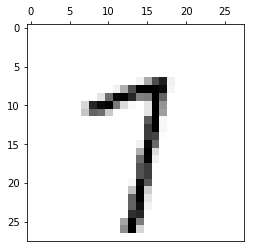

7


In [4]:
MNISTtools.show(xtrain[:, 42])
print(ltrain[42])

Answer: The mage with index 42 corresponded to its label.

##### 3

In [5]:
print(np.min(xtrain))
print(np.max(xtrain))
print(type(xtrain))

0
255
<type 'numpy.ndarray'>


##### 4

In [6]:
def normalize_MNIST_images(x):
    return ((x-127.5)/127.5).astype(np.float64)

##### 5

In [7]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(0, lbl.size)] = 1
    return d
dtrain = label2onehot(ltrain)
print(dtrain[:,42])
print(ltrain[42])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


##### 6

In [8]:
def onehot2label(d):
    lbl = d.argmax(axis=0)
    return lbl

In [9]:
print(all(ltrain==onehot2label(dtrain)))

True


# Activation Functions

##### 7

In [10]:
def softmax(a):
    div = np.exp(a - a.max(axis=0))
    return div / div.sum(axis=0)

##### 8

Proof:

Left Side

= $ \frac{exp(a_{i}) * \sum_{j=1}^{10} exp(a_{j})-(exp(a_{i})^2}{(\sum_{j=1}^{10} exp(a_{j}))^2} $

= $ g(a)_{i} - (g(a)_{i})^2 $

= $ g(a)_{i}(1-g(a)_{i}) $

= Right Side

##### 9

Proof:

Left Side

= $ \frac{-exp(a_{i}) * exp(a_{j})}{(\sum_{j=1}^{10} exp(a_{j}))^2} $

= $ -g(a)_{i} * g(a)_{j} (i \neq j) $

= Right Side

##### 10

In [11]:
def softmaxp(a, e):
    g = softmax(a)
    return g*e-(g*e).sum(axis=0)*g

##### 11

In [12]:
eps = 1e-6 # finite difference step
a = np.random.randn(10, 200) # random inputs
e = np.random.randn(10, 200) # random directions
diff = softmaxp(a, e)
diff_approx = (softmax(a+eps*e)-softmax(a))/eps
rel_error = np.abs(diff - diff_approx).mean() / np.abs(diff_approx).mean()
print(rel_error, 'should be smaller than 1e-6')

(4.924953639781273e-07, 'should be smaller than 1e-6')


##### 12

In [13]:
def relu(a):
    return (a>0)*a
def relup(a, e):
    return (a>0)*e

# Back Propogation

##### 13

In [14]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2

In [15]:
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit = init_shallow(Ni, Nh, No)
saved_init_net = copy.deepcopy(netinit)

##### 14

In [16]:
def forwardprop_shallow(x, net):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    y = softmax(a2)
    return y

xtrain = normalize_MNIST_images(xtrain)
yinit = forwardprop_shallow(xtrain, netinit)

##### 15

In [17]:
def eval_loss(y, d):
    return -np.sum(d*np.log(y))/d.size
print(eval_loss(yinit, dtrain), 'should be around .26')

(0.27118522872851974, 'should be around .26')


##### 16

In [18]:
# This is the function for calculating prediction error rate
# Lower error rate indicates better model performance
def eval_perfs(y, lbl):
    return np.sum(np.not_equal(np.argmax(y,axis=0),lbl))*1.0/lbl.size
print(eval_perfs(yinit, ltrain))

0.9243833333333333


##### 17

In [19]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    # Forward Process
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    y = softmax(a2)
    # Calculate delta
    d2 = softmaxp(a2, -d/y)
    d1 = relup(a1, W2.T.dot(d2))
    # Gradient Descent
    W2 -= gamma*d2.dot(h1.T)
    W1 -= gamma*d1.dot(x.T)
    b2 -= gamma*d2.sum(axis=1).reshape(No,1)
    b1 -= gamma*d1.sum(axis=1).reshape(Nh,1)
    
    return W1, b1, W2, b2

##### 18

In [20]:
def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    for t in range(0, T):
        net = update_shallow(x,d,net,gamma)
        if t % 9 == 0:
            ypred = forwardprop_shallow(x,net)
            loss = eval_loss(ypred,d)
            acc = eval_perfs(ypred,lbl)
            print("step= "+str(t)+" loss= "+str(loss)+" error_rate= "+str(acc))
    return net

In [21]:
nettrain = backprop_shallow(xtrain, dtrain, netinit, T=100)

step= 0 loss= 0.2430193361126099 error_rate= 0.8878666666666667
step= 9 loss= 0.16869965299928635 error_rate= 0.5073333333333333
step= 18 loss= 0.1279906442613118 error_rate= 0.3253666666666667
step= 27 loss= 0.09777314424609186 error_rate= 0.26998333333333335
step= 36 loss= 0.07894282861651937 error_rate= 0.19198333333333334
step= 45 loss= 0.0785060681980576 error_rate= 0.22806666666666667
step= 54 loss= 0.06528554301666793 error_rate= 0.18001666666666666
step= 63 loss= 0.05793436021863722 error_rate= 0.1541
step= 72 loss= 0.05416872516005859 error_rate= 0.14478333333333335
step= 81 loss= 0.05144506038285361 error_rate= 0.13893333333333333
step= 90 loss= 0.04927710173328055 error_rate= 0.13403333333333334
step= 99 loss= 0.04748423392766081 error_rate= 0.12971666666666667


##### 19

In [22]:
xtest, ltest = MNISTtools.load(dataset = "testing", path = "/datasets/MNIST")
xtest = normalize_MNIST_images(xtest)
dtest = label2onehot(ltest)
print(xtest.shape)
print(ltest.shape)

(784, 10000)
(10000,)


In [23]:
ypred = forwardprop_shallow(xtest,nettrain)
loss = eval_loss(ypred,dtest)
acc = eval_perfs(ypred,ltest)
print("Test Set:")
print("loss= "+str(loss)+" error_rate= "+str(acc))

Test Set:
loss= 0.04489039280379487 error_rate= 0.1209


##### 20

In [47]:
def backprop_minibatch_shallow(x, d, net, T, B=100, gamma=.05):
    N = x.shape[1]
    lbl = onehot2label(d)
    for t in range(0, T):
        for l in range(0, (N+B-1)/B):
            idx = np.arange(B*l, min(B*(l+1), N))
            net = update_shallow(x[:,idx],d[:,idx],net,gamma)
        y = forwardprop_shallow(x, net)
        loss = eval_loss(y,d)
        acc = eval_perfs(y,lbl)
        print("epoch= "+str(t)+" loss= "+str(loss)+" error_rate= "+str(acc))
    return net

Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit_minibatch = init_shallow(Ni, Nh, No)
netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit_minibatch, 5, B=100)

epoch= 0 loss= 0.03489616399533046 error_rate= 0.1109
epoch= 1 loss= 0.026066686567975405 error_rate= 0.08073333333333334
epoch= 2 loss= 0.021810754739571583 error_rate= 0.06761666666666667
epoch= 3 loss= 0.019421813204439177 error_rate= 0.0605
epoch= 4 loss= 0.017647700578601194 error_rate= 0.054933333333333334


##### 21

In [48]:
ypred = forwardprop_shallow(xtest,netminibatch)
loss = eval_loss(ypred,dtest)
acc = eval_perfs(ypred,ltest)
print("Test Set:")
print("loss= "+str(loss)+" error_rate= "+str(acc))

Test Set:
loss= 0.0176970714010138 error_rate= 0.0552


Answer:

Compared to the results of non-minibatch training, the minibatch training process is more effective and efficient for this task.

We can even achieve lower error rate with less training step.

# Experiment with network topology and learning parameters

##### 22

### Hidden layer --- 16 neurons

In [29]:
Ni = xtrain.shape[0]
Nh = 16
No = dtrain.shape[0]
netinit_16 = init_shallow(Ni, Nh, No)
nettrain_16 = backprop_shallow(xtrain, dtrain, netinit_16, T=100)

step= 0 loss= 0.24175236568455205 error_rate= 0.8944166666666666
step= 9 loss= 0.20831347299780903 error_rate= 0.7370333333333333
step= 18 loss= 0.1751443833862672 error_rate= 0.5445666666666666
step= 27 loss= 0.1747082363623221 error_rate= 0.5669
step= 36 loss= 0.13796551781921465 error_rate= 0.45866666666666667
step= 45 loss= 0.11618259002010299 error_rate= 0.35683333333333334
step= 54 loss= 0.1092621518476823 error_rate= 0.3569833333333333
step= 63 loss= 0.09203620442943036 error_rate= 0.2847
step= 72 loss= 0.08407570109825377 error_rate= 0.2435
step= 81 loss= 0.0769016282224372 error_rate= 0.2442
step= 90 loss= 0.06924124716284287 error_rate= 0.18746666666666667
step= 99 loss= 0.06375287815778367 error_rate= 0.18015


In [30]:
ypred = forwardprop_shallow(xtest,nettrain_16)
loss = eval_loss(ypred,dtest)
acc = eval_perfs(ypred,ltest)
print("Test Set:")
print("loss= "+str(loss)+" error_rate= "+str(acc))

Test Set:
loss= 0.061824542327798035 error_rate= 0.1744


### Hidden layer --- 256 neurons

In [31]:
Ni = xtrain.shape[0]
Nh = 256
No = dtrain.shape[0]
netinit_256 = init_shallow(Ni, Nh, No)
nettrain_256 = backprop_shallow(xtrain, dtrain, netinit_256, T=100)

step= 0 loss= 0.2574284472677842 error_rate= 0.8536666666666667
step= 9 loss= 0.13875183397055119 error_rate= 0.3358833333333333
step= 18 loss= 0.10322581516892267 error_rate= 0.29505
step= 27 loss= 0.08380603212149584 error_rate= 0.2381
step= 36 loss= 0.07142643231639065 error_rate= 0.2047
step= 45 loss= 0.06272336499522241 error_rate= 0.17456666666666668
step= 54 loss= 0.05772220449036079 error_rate= 0.1579
step= 63 loss= 0.05331030798594166 error_rate= 0.14643333333333333
step= 72 loss= 0.05031857174278993 error_rate= 0.13521666666666668
step= 81 loss= 0.0477361181356213 error_rate= 0.13061666666666666
step= 90 loss= 0.04578811171659701 error_rate= 0.12305
step= 99 loss= 0.04415729540817198 error_rate= 0.12135


In [32]:
ypred = forwardprop_shallow(xtest,nettrain_256)
loss = eval_loss(ypred,dtest)
acc = eval_perfs(ypred,ltest)
print("Test Set:")
print("loss= "+str(loss)+" error_rate= "+str(acc))

Test Set:
loss= 0.04182320798556537 error_rate= 0.1141


Comparison:

As number of hidden neurons increases from 16, 64 to 256, the model is getting better. 

Because the loss is going down and the error rate is going down after same number of training steps

##### 23

### Learning Rate --- 0.02

In [34]:
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit_rate_2 = init_shallow(Ni, Nh, No)
net_rate_2 = backprop_shallow(xtrain, dtrain, netinit_rate_2, T=100, gamma=0.02)

step= 0 loss= 0.22939790575002703 error_rate= 0.8465833333333334
step= 9 loss= 0.19524832126227606 error_rate= 0.6226166666666667
step= 18 loss= 0.17022049864994773 error_rate= 0.47763333333333335
step= 27 loss= 0.14933730564077774 error_rate= 0.38326666666666664
step= 36 loss= 0.13198289926954745 error_rate= 0.31756666666666666
step= 45 loss= 0.11778348077432663 error_rate= 0.2749666666666667
step= 54 loss= 0.10630154344266261 error_rate= 0.24683333333333332
step= 63 loss= 0.09701361255187078 error_rate= 0.22625
step= 72 loss= 0.08952575633558278 error_rate= 0.2109
step= 81 loss= 0.08343345759444362 error_rate= 0.19883333333333333
step= 90 loss= 0.07841096551047062 error_rate= 0.18803333333333333
step= 99 loss= 0.07421686268256289 error_rate= 0.18073333333333333


In [35]:
ypred = forwardprop_shallow(xtest,net_rate_2)
loss = eval_loss(ypred,dtest)
acc = eval_perfs(ypred,ltest)
print("Test Set:")
print("loss= "+str(loss)+" error_rate= "+str(acc))

Test Set:
loss= 0.07171615919625568 error_rate= 0.1691


### Learning Rate --- 0.08

In [36]:
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit_rate_8= init_shallow(Ni, Nh, No)
net_rate_8 = backprop_shallow(xtrain, dtrain, netinit_rate_8, T=100, gamma=0.08)

step= 0 loss= 0.2596018604796745 error_rate= 0.9005333333333333
step= 9 loss= 0.17398080108040934 error_rate= 0.62585
step= 18 loss= 0.12968476965788703 error_rate= 0.37776666666666664
step= 27 loss= 0.09220647576151586 error_rate= 0.23083333333333333
step= 36 loss= 0.07496457109781733 error_rate= 0.22413333333333332
step= 45 loss= 0.06600055210112958 error_rate= 0.18598333333333333
step= 54 loss= 0.06728782166276785 error_rate= 0.21426666666666666
step= 63 loss= 0.055450686745516856 error_rate= 0.16928333333333334
step= 72 loss= 0.050364439015061685 error_rate= 0.14673333333333333
step= 81 loss= 0.04816757891444816 error_rate= 0.14211666666666667
step= 90 loss= 0.04572295799456231 error_rate= 0.13073333333333334
step= 99 loss= 0.04363880286458485 error_rate= 0.12321666666666667


In [37]:
ypred = forwardprop_shallow(xtest,net_rate_8)
loss = eval_loss(ypred,dtest)
acc = eval_perfs(ypred,ltest)
print("Test Set:")
print("loss= "+str(loss)+" error_rate= "+str(acc))

Test Set:
loss= 0.0416235876500553 error_rate= 0.1155


Comparison:

As the learning rate increases from 0.02, 0.05 to 0.08, the model performance becomes better.

Because in the results obtained after same steps of training, the loss and error rate are all going down. 

##### 24

### Minibatch --- 50

In [38]:
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit_batch_50= init_shallow(Ni, Nh, No)
netminibatch_50 = backprop_minibatch_shallow(xtrain, dtrain, netinit_batch_50, 5, B=50)

epoch= 0 loss= 0.026885692268959416 error_rate= 0.08336666666666667
epoch= 1 loss= 0.021642568990659146 error_rate= 0.06736666666666667
epoch= 2 loss= 0.01910729397863608 error_rate= 0.0605
epoch= 3 loss= 0.015705528835534048 error_rate= 0.049466666666666666
epoch= 4 loss= 0.013521860648351557 error_rate= 0.04248333333333333


In [39]:
ypred = forwardprop_shallow(xtest,netminibatch_50)
loss = eval_loss(ypred,dtest)
acc = eval_perfs(ypred,ltest)
print("Test Set:")
print("loss= "+str(loss)+" error_rate= "+str(acc))

Test Set:
loss= 0.01429047319706763 error_rate= 0.0426


### Minibatch --- 200

In [40]:
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit_batch_200= init_shallow(Ni, Nh, No)
netminibatch_200 = backprop_minibatch_shallow(xtrain, dtrain, netinit_batch_200, 5, B=200)

epoch= 0 loss= 0.0382946689204892 error_rate= 0.11913333333333333
epoch= 1 loss= 0.030711723758992913 error_rate= 0.09325
epoch= 2 loss= 0.026506088427784718 error_rate= 0.08078333333333333
epoch= 3 loss= 0.023644822998864324 error_rate= 0.07151666666666667
epoch= 4 loss= 0.021352521388454025 error_rate= 0.0642


In [41]:
ypred = forwardprop_shallow(xtest,netminibatch_200)
loss = eval_loss(ypred,dtest)
acc = eval_perfs(ypred,ltest)
print("Test Set:")
print("loss= "+str(loss)+" error_rate= "+str(acc))

Test Set:
loss= 0.02165998055815807 error_rate= 0.064


Comparison:

If we compare the result for the situation of minibatch = 50, 100 and 200 for trainging 5 epochs, the lower minibatch will bring better model performance after 5 epochs since it will bring lower loss value and lower error rate.

##### 25

In [45]:
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit_batch_trial= init_shallow(Ni, Nh, No)
netminibatch_trial = backprop_minibatch_shallow(xtrain, dtrain, netinit_batch_trial, 30, B=100)

epoch= 0 loss= 0.034438980714173006 error_rate= 0.10761666666666667
epoch= 1 loss= 0.026749341134644694 error_rate= 0.08323333333333334
epoch= 2 loss= 0.02191498933698583 error_rate= 0.06771666666666666
epoch= 3 loss= 0.018869483358886083 error_rate= 0.05918333333333333
epoch= 4 loss= 0.01700183106195469 error_rate= 0.053233333333333334
epoch= 5 loss= 0.015189994678442894 error_rate= 0.047066666666666666
epoch= 6 loss= 0.0138212475038886 error_rate= 0.041933333333333336
epoch= 7 loss= 0.012773047033702554 error_rate= 0.03871666666666667
epoch= 8 loss= 0.011728144344917974 error_rate= 0.035333333333333335
epoch= 9 loss= 0.010939820244228172 error_rate= 0.03306666666666667
epoch= 10 loss= 0.010253791025739317 error_rate= 0.031166666666666665
epoch= 11 loss= 0.009620906466983447 error_rate= 0.02925
epoch= 12 loss= 0.009121200154046149 error_rate= 0.028033333333333334
epoch= 13 loss= 0.008645798449270327 error_rate= 0.0268
epoch= 14 loss= 0.008161415212400304 error_rate= 0.0252
epoch= 15 l

In [46]:
ypred = forwardprop_shallow(xtest,netminibatch_trial)
loss = eval_loss(ypred,dtest)
acc = eval_perfs(ypred,ltest)
print("Test Set:")
print("loss= "+str(loss)+" error_rate= "+str(acc))

Test Set:
loss= 0.009831804855568893 error_rate= 0.0294


Answer:

I tried some parameters and here I got the error rate of 2.9%. However, there are definitely many advacned techniques to optimize the neural network to get better result and faster training process.

# Bonus Part

### I have written another python notebook, in which I implemented a python class that support building any number of layers and any number of hidden neurons neural network. In addition, some optimization techniques are also included such as regularization, options for different optimizers (including momentum option) and options for different activation functions.

### The code for this part is in another notebook named BonusPart.ipynb . 

### Install python-mnist module and then you could try to use my code of this part.